https://chatgpt.com/c/67c4827c-efc0-8000-820b-8190d0579e8e

Me da peor rmse de train (70 si trato los nulos con un bfill). mejor eliminarlos

IMPORTAR LIBRERIAS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip install catboost

In [ ]:
# =====================
# 🔧 Configuración general
# =====================
import os
import pickle
import warnings
from datetime import datetime

# Evitar warnings
warnings.filterwarnings("ignore")

# =====================
# 📊 Manejo de datos
# =====================
import numpy as np
import pandas as pd

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Semilla para reproducibilidad
np.random.seed(42)

# =====================
# 📈 Visualización
# =====================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# =====================
# ⚙️ Preprocesamiento
# =====================
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

# =====================
# 🧠 Modelos de clasificación
# =====================
from sklearn.linear_model import Perceptron, SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# =====================
# 🔢 Modelos de regresión
# =====================
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# =====================
# 📏 Métricas
# =====================
from sklearn import metrics
from sklearn.metrics import mean_squared_error

# =====================
# 🕵️ Interpretabilidad
# =====================
import shap

# =====================
# ⏳ Series temporales
# =====================
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


IMPORTAR DATASET

In [ ]:
# Importamos el dataset
df = pd.read_pickle('/content/drive/MyDrive/Master_Data_Science/TFM SP500 COMPARTIDO/NOTEBOOKS FINALES/data01032025.pkl')
#df = pd.read_pickle('/content/data01032025.pkl')

In [ ]:
df.shape

(5256, 34)

In [ ]:
# Tenemos dos columnas identicas. Eliminamos una
print((df['Yearly_Return'] != df['Price_Growth']).sum())

df.drop('Price_Growth', axis = 1, inplace = True)

494


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5256 entries, 0 to 5297
Data columns (total 33 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   ticker                                 5256 non-null   object 
 1   year                                   5256 non-null   int64  
 2   totalRevenue                           5256 non-null   float64
 3   depreciationAndAmortization            5256 non-null   float64
 4   ebitda                                 5256 non-null   float64
 5   netIncome                              5256 non-null   float64
 6   cashAndCashEquivalentsAtCarryingValue  5256 non-null   float64
 7   totalLiabilities                       5256 non-null   float64
 8   totalShareholderEquity                 5256 non-null   float64
 9   commonStockSharesOutstanding           5256 non-null   float64
 10  shortLongTermDebtTotal                 5256 non-null   float64
 11  capitalEx

In [ ]:
# Eliminamos la columna sector porque hemos comprobado que no contribuye a la predicciónç

df.drop('sector', axis = 1, inplace = True)


In [ ]:
df.shape

(5256, 32)

AJUSTES FORMATO

In [ ]:
# Asegurar que la columna de año está ordenada
df = df.sort_values(by=['ticker', 'year'])

ENRIQUEZER DATOS

In [ ]:
df.head()

,ticker,year,totalRevenue,depreciationAndAmortization,ebitda,netIncome,cashAndCashEquivalentsAtCarryingValue,totalLiabilities,totalShareholderEquity,commonStockSharesOutstanding,shortLongTermDebtTotal,capitalExpenditures,cashflowFromInvestment,dividendPayout,cashflowFromFinancing,operatingCashflow,Year-End Price,totalAssets,totalCurrentAssets,totalCurrentLiabilities,ROE,ROIC,Debt_to_Equity,Earnings_Per_Share,P/E_Ratio,Net_Income_Margin,Revenue_Per_Share,P/S_Ratio,Market_Cap,Yearly_Return,return_5y,Sales_Growth
0,A,2013,3894000000.00,199000000.00,1098000000.00,724000000.00,2675000000.00,5397000000.00,5286000000.00,602000000.00,2653000000.00,195000000.00,-248000000.00,156000000.00,-554000000.00,1152000000.00,37.73,10686000000.00,4983000000.00,1602000000.00,0.14,556317954.42,1.02,1.20,31.38,0.19,6.47,5.83,22715972835.34,NaN,NaN,NaN
1,A,2014,4048000000.00,197000000.00,808000000.00,504000000.00,2218000000.00,5511000000.00,5301000000.00,608000000.00,2720000000.00,205000000.00,-230000000.00,176000000.00,-117000000.00,731000000.00,37.69,10815000000.00,5509000000.00,1692000000.00,0.10,315501360.91,1.04,0.83,45.47,0.12,6.66,5.66,22917108510.40,-0.00,NaN,0.04
2,A,2015,4038000000.00,156000000.00,665000000.00,401000000.00,2003000000.00,3309000000.00,4167000000.00,611000000.00,1596000000.00,98000000.00,-400000000.00,133000000.00,-1089000000.00,512000000.00,39.00,7479000000.00,3686000000.00,976000000.00,0.10,337490480.51,0.79,0.66,59.42,0.10,6.61,5.90,23828127554.30,0.03,NaN,-0.00
3,A,2016,4202000000.00,152000000.00,768000000.00,462000000.00,2289000000.00,3548000000.00,4243000000.00,614000000.00,1888000000.00,139000000.00,-238000000.00,150000000.00,-268000000.00,793000000.00,42.96,7794000000.00,3635000000.00,945000000.00,0.11,373116121.76,0.84,0.75,57.09,0.11,6.84,6.28,26375204751.58,0.10,NaN,0.04
4,A,2017,4472000000.00,120000000.00,1002000000.00,684000000.00,2678000000.00,3591000000.00,4831000000.00,322000000.00,2000000000.00,176000000.00,-304000000.00,170000000.00,-202000000.00,889000000.00,63.71,8426000000.00,4169000000.00,1263000000.00,0.14,691488164.86,0.74,2.12,29.99,0.15,13.89,4.59,20515623726.06,0.48,NaN,0.06


In [ ]:
# Añadimos una variable de tasas de interes impuestas por la FED en cada año. Ha resultado aportar mucho al modelo

tasas_interes_fed = {
    2013: 0.25,
    2014: 0.25,
    2015: 0.25,
    2016: 0.50,
    2017: 1.50,
    2018: 2.50,
    2019: 1.75,
    2020: 0.25,
    2021: 0.25,
    2022: 4.25,
    2023: 4.50,
    2024: 4.25
}

In [ ]:
df.shape

(5256, 32)

In [ ]:
# agregar la columna con la tasa de interés correspondiente a cada año
df['Fed_Interest_rate'] = df["year"].map(tasas_interes_fed)

In [ ]:
df.shape

(5256, 33)

In [ ]:
# mostrar primeras filas para verificar
df.head()

,ticker,year,totalRevenue,depreciationAndAmortization,ebitda,netIncome,cashAndCashEquivalentsAtCarryingValue,totalLiabilities,totalShareholderEquity,commonStockSharesOutstanding,shortLongTermDebtTotal,capitalExpenditures,cashflowFromInvestment,dividendPayout,cashflowFromFinancing,operatingCashflow,Year-End Price,totalAssets,totalCurrentAssets,totalCurrentLiabilities,ROE,ROIC,Debt_to_Equity,Earnings_Per_Share,P/E_Ratio,Net_Income_Margin,Revenue_Per_Share,P/S_Ratio,Market_Cap,Yearly_Return,return_5y,Sales_Growth,Fed_Interest_rate
0,A,2013,3894000000.00,199000000.00,1098000000.00,724000000.00,2675000000.00,5397000000.00,5286000000.00,602000000.00,2653000000.00,195000000.00,-248000000.00,156000000.00,-554000000.00,1152000000.00,37.73,10686000000.00,4983000000.00,1602000000.00,0.14,556317954.42,1.02,1.20,31.38,0.19,6.47,5.83,22715972835.34,NaN,NaN,NaN,0.25
1,A,2014,4048000000.00,197000000.00,808000000.00,504000000.00,2218000000.00,5511000000.00,5301000000.00,608000000.00,2720000000.00,205000000.00,-230000000.00,176000000.00,-117000000.00,731000000.00,37.69,10815000000.00,5509000000.00,1692000000.00,0.10,315501360.91,1.04,0.83,45.47,0.12,6.66,5.66,22917108510.40,-0.00,NaN,0.04,0.25
2,A,2015,4038000000.00,156000000.00,665000000.00,401000000.00,2003000000.00,3309000000.00,4167000000.00,611000000.00,1596000000.00,98000000.00,-400000000.00,133000000.00,-1089000000.00,512000000.00,39.00,7479000000.00,3686000000.00,976000000.00,0.10,337490480.51,0.79,0.66,59.42,0.10,6.61,5.90,23828127554.30,0.03,NaN,-0.00,0.25
3,A,2016,4202000000.00,152000000.00,768000000.00,462000000.00,2289000000.00,3548000000.00,4243000000.00,614000000.00,1888000000.00,139000000.00,-238000000.00,150000000.00,-268000000.00,793000000.00,42.96,7794000000.00,3635000000.00,945000000.00,0.11,373116121.76,0.84,0.75,57.09,0.11,6.84,6.28,26375204751.58,0.10,NaN,0.04,0.50
4,A,2017,4472000000.00,120000000.00,1002000000.00,684000000.00,2678000000.00,3591000000.00,4831000000.00,322000000.00,2000000000.00,176000000.00,-304000000.00,170000000.00,-202000000.00,889000000.00,63.71,8426000000.00,4169000000.00,1263000000.00,0.14,691488164.86,0.74,2.12,29.99,0.15,13.89,4.59,20515623726.06,0.48,NaN,0.06,1.50


In [ ]:
# Verificamos que hay solo un interest rate para cada año
df.groupby("year")["Fed_Interest_rate"].unique()

,Fed_Interest_rate
year,
2013,[0.25]
2014,[0.25]
2015,[0.25]
2016,[0.5]
2017,[1.5]
2018,[2.5]
2019,[1.75]
2020,[0.25]
2021,[0.25]


TRANSFORMACIONES INICIALES

In [ ]:
# Calcular media móvil de 3 años incluyendo año actual el año actual
df['Year_End_Price_MA_3Y'] = df.groupby('ticker')['Year-End Price'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# Mostrar resultados
print(df[['ticker', 'year', 'Year-End Price', 'Year_End_Price_MA_3Y']].head(10))


  ticker  year  Year-End Price  Year_End_Price_MA_3Y
0      A  2013           37.73                 37.73
1      A  2014           37.69                 37.71
2      A  2015           39.00                 38.14
3      A  2016           42.96                 39.88
4      A  2017           63.71                 48.56
5      A  2018           64.78                 57.15
6      A  2019           82.61                 70.37
7      A  2020          115.47                 87.62
8      A  2021          156.47                118.18
9      A  2022          147.82                139.92


In [ ]:
# Calcular media móvil de 5 años incluyendo año actual el año actual
df['Year_End_Price_MA_5Y'] = df.groupby('ticker')['Year-End Price'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())

# Mostrar resultados
print(df[['ticker', 'year', 'Year-End Price', 'Year_End_Price_MA_5Y']].head(10))

  ticker  year  Year-End Price  Year_End_Price_MA_5Y
0      A  2013           37.73                 37.73
1      A  2014           37.69                 37.71
2      A  2015           39.00                 38.14
3      A  2016           42.96                 39.35
4      A  2017           63.71                 44.22
5      A  2018           64.78                 49.63
6      A  2019           82.61                 58.61
7      A  2020          115.47                 73.91
8      A  2021          156.47                 96.61
9      A  2022          147.82                113.43


In [ ]:
# lista de variables para crear lags y pct_change

variables_lag = [
    "ROE", "ROIC", "Debt_to_Equity", "Earnings_Per_Share", "P/E_Ratio",
    "Net_Income_Margin", "Revenue_Per_Share", "P/S_Ratio", "Market_Cap",
    "Yearly_Return", "return_5y", "Sales_Growth","Year-End Price"]

# crear lags para cada variable
for var in variables_lag:
  # Creamos lag de 1 a 3 de cada ratio
  n_lags = 1
  for i in range(n_lags):
    df[f'{var}_lag{i+1}'] = df.groupby('ticker')[var].shift(i+1)

# crear pct_change para cada variable
for var in variables_lag:
  # Creamos lag de 1 a 3 de cada ratio
    df[f'{var}_pct_change'] = df.groupby('ticker')[var].pct_change()

MODELO

In [ ]:
# validamos que no tenemos ya ninguna variable no numerica
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5256 entries, 0 to 5297
Data columns (total 61 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   ticker                                 5256 non-null   object 
 1   year                                   5256 non-null   int64  
 2   totalRevenue                           5256 non-null   float64
 3   depreciationAndAmortization            5256 non-null   float64
 4   ebitda                                 5256 non-null   float64
 5   netIncome                              5256 non-null   float64
 6   cashAndCashEquivalentsAtCarryingValue  5256 non-null   float64
 7   totalLiabilities                       5256 non-null   float64
 8   totalShareholderEquity                 5256 non-null   float64
 9   commonStockSharesOutstanding           5256 non-null   float64
 10  shortLongTermDebtTotal                 5256 non-null   float64
 11  capitalEx

In [ ]:
# visualizamos las variables con mas nulos
print(df.isna().sum().sort_values(ascending=False).head(8))

return_5y_lag1              2944
return_5y_pct_change        2944
return_5y                   2461
Yearly_Return_pct_change     989
Sales_Growth_pct_change      988
Yearly_Return_lag1           988
Sales_Growth_lag1            988
ROE_lag1                     494
dtype: int64


In [ ]:
# eliminar variables con demasiados nulos

nulls = df.isna().sum().sort_values(ascending=False)
COLUMNS_TO_DROP = nulls[nulls>500].index.tolist()
print(COLUMNS_TO_DROP)

df.drop(COLUMNS_TO_DROP, axis=1, inplace=True)

['return_5y_lag1', 'return_5y_pct_change', 'return_5y', 'Yearly_Return_pct_change', 'Sales_Growth_pct_change', 'Yearly_Return_lag1', 'Sales_Growth_lag1']


In [ ]:
# por el momento eliminamos nulos
df = df.dropna()

In [ ]:
df.isna().sum().sort_values(ascending=False).head()

,0
ticker,0
Revenue_Per_Share_lag1,0
Yearly_Return,0
Sales_Growth,0
Fed_Interest_rate,0


In [ ]:
df.shape

(4762, 54)

In [ ]:
df.value_counts('year')

,count
year,
2023,494
2022,493
2021,491
2020,489
2019,483
2018,477
2017,468
2016,464
2015,458


In [ ]:
# Creamos la variable next_year_end_price

df['next_year_end_price'] = df.groupby('ticker')['Year-End Price'].shift(-1)

In [ ]:
# Con el codigo de abajo obtenemos los year end price de 2024 con la libreria yfinance y lo guardamos en un pickle.
#Lo dejamos comentado para que no se ejecute cada vez.

'''import yfinance as yf

tickers = df[df['next_year_end_price'].isna()]['ticker'].tolist()

# Definir la fecha de fin de año 2024
fecha_fin_2024 = "2024-12-31"

# Crear un diccionario para almacenar los precios de cierre
precios_cierre = {}

# Obtener lista de empresas del S&P 500 desde Wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
tickers = pd.read_html(url)[0]['Symbol'].tolist()

# Descargar datos en bloque
data = yf.download(tickers, start="2024-12-31", end="2025-01-01", progress=True)['Close']

# Guardar los precios de cierre de fin de año
df_precios = data.T  # Transponer para tener tickers como índice
df_precios.columns = ['Year-End Price 2024']

# Ver los primeros datos
print(df_precios.head())

# Guardamos df_precios en un pickle
df_precios.to_pickle('/content/drive/MyDrive/Master_Data_Science/TFM SP500 COMPARTIDO/NOTEBOOKS FINALES/df_precios.pkl')
''';


In [ ]:
# Leemos el pickle y lo asignamos a df_precios
#df_precios = pd.read_pickle('/content/df_precios.pkl')
df_precios = pd.read_pickle('/content/drive/MyDrive/Master_Data_Science/TFM SP500 COMPARTIDO/NOTEBOOKS FINALES/df_precios.pkl')

In [ ]:
df.isna().sum().sort_values(ascending=False).head()

,0
next_year_end_price,494
P/S_Ratio_lag1,0
Sales_Growth,0
Fed_Interest_rate,0
Year_End_Price_MA_3Y,0


In [ ]:
df_precios.head()

,Year-End Price 2024
Ticker,
A,134.34
AAPL,250.14
ABBV,176.04
ABNB,131.41
ABT,112.52


In [ ]:
# Convertir df_precios en diccionario clave: ticker, valor: precio
diccionario = df_precios.iloc[:, 0].to_dict()

# Solo modificar 'next_year_end_price' en las filas donde 'year' es 2023
df.loc[df['year'] == 2023, 'next_year_end_price'] = df['ticker'].map(diccionario)


In [ ]:
df.head(10)

,ticker,year,totalRevenue,depreciationAndAmortization,ebitda,netIncome,cashAndCashEquivalentsAtCarryingValue,totalLiabilities,totalShareholderEquity,commonStockSharesOutstanding,shortLongTermDebtTotal,capitalExpenditures,cashflowFromInvestment,dividendPayout,cashflowFromFinancing,operatingCashflow,Year-End Price,totalAssets,totalCurrentAssets,totalCurrentLiabilities,ROE,ROIC,Debt_to_Equity,Earnings_Per_Share,P/E_Ratio,Net_Income_Margin,Revenue_Per_Share,P/S_Ratio,Market_Cap,Yearly_Return,Sales_Growth,Fed_Interest_rate,Year_End_Price_MA_3Y,Year_End_Price_MA_5Y,ROE_lag1,ROIC_lag1,Debt_to_Equity_lag1,Earnings_Per_Share_lag1,P/E_Ratio_lag1,Net_Income_Margin_lag1,Revenue_Per_Share_lag1,P/S_Ratio_lag1,Market_Cap_lag1,Year-End Price_lag1,ROE_pct_change,ROIC_pct_change,Debt_to_Equity_pct_change,Earnings_Per_Share_pct_change,P/E_Ratio_pct_change,Net_Income_Margin_pct_change,Revenue_Per_Share_pct_change,P/S_Ratio_pct_change,Market_Cap_pct_change,Year-End Price_pct_change,next_year_end_price
1,A,2014,4048000000.00,197000000.00,808000000.00,504000000.00,2218000000.00,5511000000.00,5301000000.00,608000000.00,2720000000.00,205000000.00,-230000000.00,176000000.00,-117000000.00,731000000.00,37.69,10815000000.00,5509000000.00,1692000000.00,0.10,315501360.91,1.04,0.83,45.47,0.12,6.66,5.66,22917108510.40,-0.00,0.04,0.25,37.71,37.71,0.14,556317954.42,1.02,1.20,31.38,0.19,6.47,5.83,22715972835.34,37.73,-0.31,-0.43,0.02,-0.31,0.45,-0.33,0.03,-0.03,0.01,-0.00,39.00
2,A,2015,4038000000.00,156000000.00,665000000.00,401000000.00,2003000000.00,3309000000.00,4167000000.00,611000000.00,1596000000.00,98000000.00,-400000000.00,133000000.00,-1089000000.00,512000000.00,39.00,7479000000.00,3686000000.00,976000000.00,0.10,337490480.51,0.79,0.66,59.42,0.10,6.61,5.90,23828127554.30,0.03,-0.00,0.25,38.14,38.14,0.10,315501360.91,1.04,0.83,45.47,0.12,6.66,5.66,22917108510.40,37.69,0.01,0.07,-0.24,-0.21,0.31,-0.20,-0.01,0.04,0.04,0.03,42.96
3,A,2016,4202000000.00,152000000.00,768000000.00,462000000.00,2289000000.00,3548000000.00,4243000000.00,614000000.00,1888000000.00,139000000.00,-238000000.00,150000000.00,-268000000.00,793000000.00,42.96,7794000000.00,3635000000.00,945000000.00,0.11,373116121.76,0.84,0.75,57.09,0.11,6.84,6.28,26375204751.58,0.10,0.04,0.50,39.88,39.35,0.10,337490480.51,0.79,0.66,59.42,0.10,6.61,5.90,23828127554.30,39.00,0.13,0.11,0.05,0.15,-0.04,0.11,0.04,0.06,0.11,0.10,63.71
4,A,2017,4472000000.00,120000000.00,1002000000.00,684000000.00,2678000000.00,3591000000.00,4831000000.00,322000000.00,2000000000.00,176000000.00,-304000000.00,170000000.00,-202000000.00,889000000.00,63.71,8426000000.00,4169000000.00,1263000000.00,0.14,691488164.86,0.74,2.12,29.99,0.15,13.89,4.59,20515623726.06,0.48,0.06,1.50,48.56,44.22,0.11,373116121.76,0.84,0.75,57.09,0.11,6.84,6.28,26375204751.58,42.96,0.30,0.85,-0.11,1.82,-0.47,0.39,1.03,-0.27,-0.22,0.48,64.78
5,A,2018,4836000000.00,110000000.00,1131000000.00,316000000.00,2247000000.00,4430117469.63,4593000000.00,325000000.00,1799000000.00,177000000.00,-705000000.00,191000000.00,-797000000.00,1087000000.00,64.78,9023117469.63,3750429692.21,1876784000.64,0.07,129595886.32,0.96,0.97,66.62,0.07,14.88,4.35,21053217304.07,0.02,0.08,2.50,57.15,49.63,0.14,691488164.86,0.74,2.12,29.99,0.15,13.89,4.59,20515623726.06,63.71,-0.51,-0.81,0.30,-0.54,1.22,-0.57,0.07,-0.05,0.03,0.02,82.61
6,A,2019,5073000000.00,128000000.00,1121000000.00,1071000000.00,1382000000.00,4704000000.00,4748000000.00,309000000.00,2402000000.00,156000000.00,-1590000000.00,206000000.00,-299000000.00,1021000000.00,82.61,9452000000.00,3189000000.00,2080000000.00,0.23,873090986.39,0.99,3.47,23.84,0.21,16.42,5.03,25527407812.70,0.28,0.05,1.75,70.37,58.61,0.07,129595886.32,0.96,0.97,66.62,0.07,14.88,4.35,21053217304.07,64.78,2.28,5.74,0.03,2.56,-0.64,2.23,0.10,0.16,0.21,0.28,115.47
7,A,2020,5271000000.00,186000000.00,1106000000.00,719000000.00,1441000000.00,4754000000.00,4873000000.00,306000000.00,2359000000.00,119000000.00,-147000000.00,222000000.00,-717000000.00,92100

In [ ]:
df.isna().sum().sort_values(ascending=False).head()

,0
next_year_end_price,2
P/S_Ratio_lag1,0
Sales_Growth,0
Fed_Interest_rate,0
Year_End_Price_MA_3Y,0


In [ ]:
# Borramos los dos ultimos registros nulos que quedan
df.dropna(subset=['next_year_end_price'], inplace=True)

In [ ]:
# Creamos la variable target:

df['next_year_return'] = (df['next_year_end_price'] / df['Year-End Price']) - 1

target = 'next_year_return'
df.drop('next_year_end_price', axis = 1, inplace = True)

In [ ]:
df.head()

,ticker,year,totalRevenue,depreciationAndAmortization,ebitda,netIncome,cashAndCashEquivalentsAtCarryingValue,totalLiabilities,totalShareholderEquity,commonStockSharesOutstanding,shortLongTermDebtTotal,capitalExpenditures,cashflowFromInvestment,dividendPayout,cashflowFromFinancing,operatingCashflow,Year-End Price,totalAssets,totalCurrentAssets,totalCurrentLiabilities,ROE,ROIC,Debt_to_Equity,Earnings_Per_Share,P/E_Ratio,Net_Income_Margin,Revenue_Per_Share,P/S_Ratio,Market_Cap,Yearly_Return,Sales_Growth,Fed_Interest_rate,Year_End_Price_MA_3Y,Year_End_Price_MA_5Y,ROE_lag1,ROIC_lag1,Debt_to_Equity_lag1,Earnings_Per_Share_lag1,P/E_Ratio_lag1,Net_Income_Margin_lag1,Revenue_Per_Share_lag1,P/S_Ratio_lag1,Market_Cap_lag1,Year-End Price_lag1,ROE_pct_change,ROIC_pct_change,Debt_to_Equity_pct_change,Earnings_Per_Share_pct_change,P/E_Ratio_pct_change,Net_Income_Margin_pct_change,Revenue_Per_Share_pct_change,P/S_Ratio_pct_change,Market_Cap_pct_change,Year-End Price_pct_change,next_year_return
1,A,2014,4048000000.00,197000000.00,808000000.00,504000000.00,2218000000.00,5511000000.00,5301000000.00,608000000.00,2720000000.00,205000000.00,-230000000.00,176000000.00,-117000000.00,731000000.00,37.69,10815000000.00,5509000000.00,1692000000.00,0.10,315501360.91,1.04,0.83,45.47,0.12,6.66,5.66,22917108510.40,-0.00,0.04,0.25,37.71,37.71,0.14,556317954.42,1.02,1.20,31.38,0.19,6.47,5.83,22715972835.34,37.73,-0.31,-0.43,0.02,-0.31,0.45,-0.33,0.03,-0.03,0.01,-0.00,0.03
2,A,2015,4038000000.00,156000000.00,665000000.00,401000000.00,2003000000.00,3309000000.00,4167000000.00,611000000.00,1596000000.00,98000000.00,-400000000.00,133000000.00,-1089000000.00,512000000.00,39.00,7479000000.00,3686000000.00,976000000.00,0.10,337490480.51,0.79,0.66,59.42,0.10,6.61,5.90,23828127554.30,0.03,-0.00,0.25,38.14,38.14,0.10,315501360.91,1.04,0.83,45.47,0.12,6.66,5.66,22917108510.40,37.69,0.01,0.07,-0.24,-0.21,0.31,-0.20,-0.01,0.04,0.04,0.03,0.10
3,A,2016,4202000000.00,152000000.00,768000000.00,462000000.00,2289000000.00,3548000000.00,4243000000.00,614000000.00,1888000000.00,139000000.00,-238000000.00,150000000.00,-268000000.00,793000000.00,42.96,7794000000.00,3635000000.00,945000000.00,0.11,373116121.76,0.84,0.75,57.09,0.11,6.84,6.28,26375204751.58,0.10,0.04,0.50,39.88,39.35,0.10,337490480.51,0.79,0.66,59.42,0.10,6.61,5.90,23828127554.30,39.00,0.13,0.11,0.05,0.15,-0.04,0.11,0.04,0.06,0.11,0.10,0.48
4,A,2017,4472000000.00,120000000.00,1002000000.00,684000000.00,2678000000.00,3591000000.00,4831000000.00,322000000.00,2000000000.00,176000000.00,-304000000.00,170000000.00,-202000000.00,889000000.00,63.71,8426000000.00,4169000000.00,1263000000.00,0.14,691488164.86,0.74,2.12,29.99,0.15,13.89,4.59,20515623726.06,0.48,0.06,1.50,48.56,44.22,0.11,373116121.76,0.84,0.75,57.09,0.11,6.84,6.28,26375204751.58,42.96,0.30,0.85,-0.11,1.82,-0.47,0.39,1.03,-0.27,-0.22,0.48,0.02
5,A,2018,4836000000.00,110000000.00,1131000000.00,316000000.00,2247000000.00,4430117469.63,4593000000.00,325000000.00,1799000000.00,177000000.00,-705000000.00,191000000.00,-797000000.00,1087000000.00,64.78,9023117469.63,3750429692.21,1876784000.64,0.07,129595886.32,0.96,0.97,66.62,0.07,14.88,4.35,21053217304.07,0.02,0.08,2.50,57.15,49.63,0.14,691488164.86,0.74,2.12,29.99,0.15,13.89,4.59,20515623726.06,63.71,-0.51,-0.81,0.30,-0.54,1.22,-0.57,0.07,-0.05,0.03,0.02,0.28


In [ ]:
# Tenemos un par de valores infinitos consecuencia de la creacion de variables. Los eliminamos

df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Convierte infinitos en NaN
df.dropna(inplace=True)  # Elimina filas con NaN


In [ ]:
# Creamos una copia del dataframe con la columna 'ticker' para poder usarlo en un futuro.
df_copy = df.copy()

In [ ]:
# Creamos un diccionario para asociar cada indice a su compañia:
indice_ticker_df = df['ticker']

df.drop('ticker', axis = 1, inplace = True)

In [ ]:
# Nos separamos el dataset entre 2023 y antes de 2023 para poder poner en practica nuestro modelo con los datos de 2023
training_df = df[df['year'] < 2023].copy()
df_23_24 = df[df['year'] == 2023].copy()

# Separa la variable objetivo (target) y las características (features)
y = training_df[target]
X = training_df.drop(columns=[target])  # Mejor usar 'columns' en lugar de 'axis=1' por claridad

y_23_24 = df_23_24[target]
X_23_24 = df_23_24.drop(columns=[target])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Los guardamos en csv para usarlo en powerbi
training_df.to_csv('/content/drive/MyDrive/Master_Data_Science/TFM SP500 COMPARTIDO/NOTEBOOKS FINALES/training_df.csv', decimal = ',')
df_23_24.to_csv('/content/drive/MyDrive/Master_Data_Science/TFM SP500 COMPARTIDO/NOTEBOOKS FINALES/df_23_24.csv', decimal = ',')

FEATURE IMPORTANCE

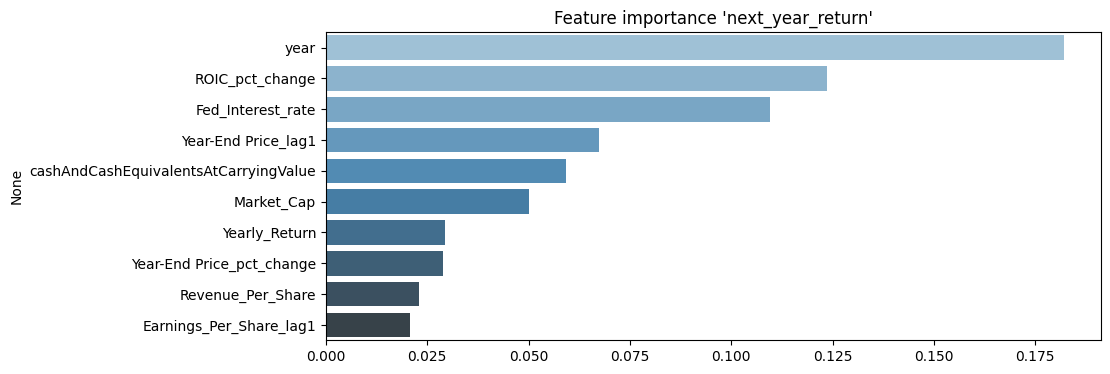

In [ ]:
params = {'random_state': 42, 'n_jobs': 4, 'n_estimators': 100, 'max_depth': 4}

# Drop 'ticker' column before creating x and y
# x, y = df_entrenar.drop([target, 'ticker'], axis=1), df_entrenar[target]  # Drop 'ticker' here

# entrena un RandomForest Classifier
clf = RandomForestRegressor(**params)
clf = clf.fit(X, y)
# Plotea las 10 mejores Features importances
features = clf.feature_importances_
columnas = X.columns
imp = pd.Series(data=features, index=columnas).sort_values(ascending=False)[:10]
plt.figure(figsize=(10,4))
plt.title("Feature importance '{}'".format(target))
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')
plt.show()

In [ ]:
for col in X_train.columns:
    if np.isinf(X_train[col]).sum() > 0:
        print(f"Columna {col} tiene valores infinitos.")
    if X_train[col].isna().sum() > 0:
        print(f"Columna {col} tiene valores NaN.")

REESCALING

In [ ]:
# guardo las columnas en una lista antes de standarizar
# el metodo scaler quita el nombre de las variables, que luego es necesario para la interpretabilidad
variables_entrenadas = X_train.columns

In [ ]:
# se estandarizan las variables
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

COMPETICIÓN DE MODELOS

In [ ]:
modelos = []
modelos.append(('LinearRegression', LinearRegression()))
modelos.append(('Ridge', Ridge(random_state=42)))
modelos.append(('SGDRegressor', SGDRegressor(random_state=42)))
modelos.append(('Lasso', Lasso(random_state=42)))
modelos.append(('ElasticNet', ElasticNet(random_state=42)))
modelos.append(('RandomForestRegressor', RandomForestRegressor(random_state=42)))
modelos.append(('GradientBoostingRegressor', GradientBoostingRegressor(random_state=42)))
modelos.append(('XGBRegressor', XGBRegressor(random_state=42)))
modelos.append(('CatBoostRegressor', CatBoostRegressor(verbose=False, random_state=42)))

In [ ]:
metricas_modelos = pd.DataFrame(columns=['modelo', 'RMSE'])
previous_best_rmse= np.inf

for nombre, modelo in modelos:

    # entrenamos el modelo
    modelo.fit(X_train, y_train)

    # hacemos la predicción sobre el dataset de test
    y_pred = modelo.predict(X_test)

    # Calcular el RMSE
    mse = metrics.mean_squared_error(y_test, y_pred)  # Calcula el MSE
    rmse = np.sqrt(mse)  # Toma la raíz cuadrada del MSE

    # imprimimos el resultado por modelo
    metricas_modelos = pd.concat([metricas_modelos,
                                  pd.DataFrame({'modelo': nombre, 'RMSE': rmse.round(3)}, index=[0])
                                  ])
    print(modelo, rmse)

    if rmse < previous_best_rmse:
        best_model = modelo
        previous_best_rmse = rmse

metricas_modelos.sort_values('RMSE', ascending=True)

LinearRegression() 1281.2374283230026
Ridge(random_state=42) 296.50021433387894
SGDRegressor(random_state=42) 40164045.4415208
Lasso(random_state=42) 0.33020327173608033
ElasticNet(random_state=42) 0.33020327173608033
RandomForestRegressor(random_state=42) 0.26753275557759154
GradientBoostingRegressor(random_state=42) 0.292688514458922
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estima

,modelo,RMSE
0,RandomForestRegressor,0.27
0,CatBoostRegressor,0.28
0,GradientBoostingRegressor,0.29
0,XGBRegressor,0.30
0,Lasso,0.33
0,ElasticNet,0.33
0,Ridge,296.50
0,LinearRegression,1281.24
0,SGDRegressor,40164045.44


In [ ]:
best_model

RandomForestRegressor(random_state=42)

In [ ]:
# Mejores parametros conseguidos con gridsearch para randomforestregressor
model = RandomForestRegressor(max_depth = 20, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 5, n_estimators = 200, random_state=42)

In [ ]:
# entrenamos el modelo
model.fit(X_train, y_train)

# hacemos la predicción sobre el dataset de test
y_pred = model.predict(X_test)

In [ ]:
# evaluación en el dataset de train
y_pred_train = model.predict(X_train)

# evaluación de la métrica
rmse_train = metrics.root_mean_squared_error(y_train, y_pred_train)
rmse_train

0.1775988036000662

In [ ]:
# evaluación en el dataset de test
y_pred_test = model.predict(X_test)

# evaluación de la métrica
rmse_test = metrics.root_mean_squared_error(y_test, y_pred_test)
rmse_test

0.28094073463379

In [ ]:
# evaluación en el dataset de prediccion(2023-2024)
y_pred_23_24 = model.predict(X_23_24)

# evaluación de la métrica
rmse_test = metrics.root_mean_squared_error(y_23_24, y_pred_23_24)
rmse_test

0.4917996768484319

In [ ]:
X_test.shape

(854, 53)

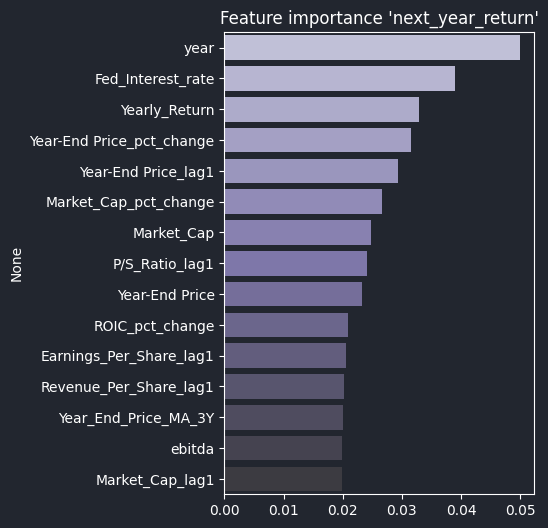

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Estilo con fondo negro
plt.style.use('dark_background')

# Plotea las mejores Features importances
features = model.feature_importances_
columnas = X.columns
imp = pd.Series(data=features, index=columnas).sort_values(ascending=False)[:15]
plt.figure(figsize=(4,6))
plt.title("Feature importance '{}'".format(target))

# Fondo del gráfico
plt.gcf().set_facecolor('#22262F')

# Fondo del área de trabajo (dentro del gráfico)
plt.gca().set_facecolor('#22262F')

ax = sns.barplot(y=imp.index, x=imp.values, palette="Purples_d", orient='h')
plt.show()

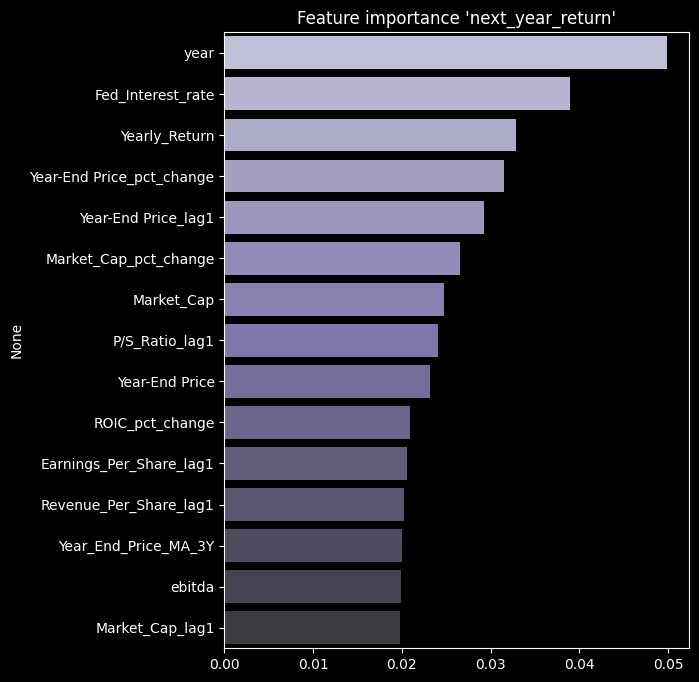

In [ ]:
import matplotlib.pyplot as plt

# Estilo con fondo negro
plt.style.use('dark_background')

# Plotea las mejores Features importances
features = model.feature_importances_
columnas = X.columns
imp = pd.Series(data=features, index=columnas).sort_values(ascending=False)[:15]
plt.figure(figsize=(6,8))
plt.title("Feature importance '{}'".format(target))
ax = sns.barplot(y=imp.index, x=imp.values, palette="Purples_d", orient='h')
plt.show()

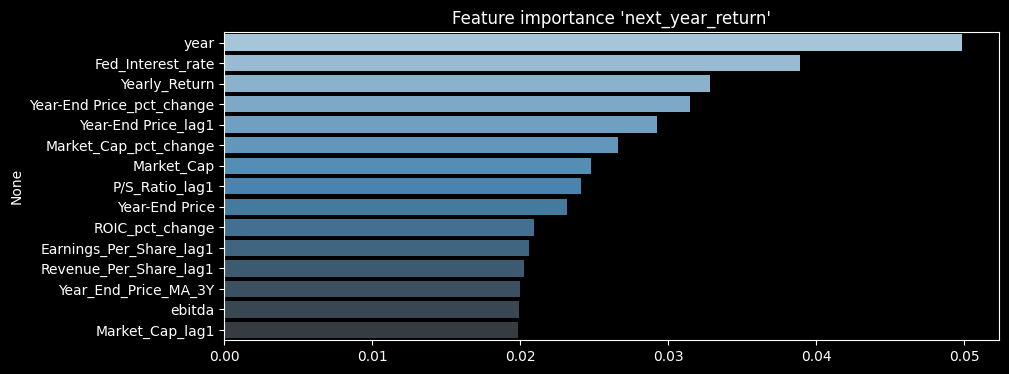

In [ ]:
# Plotea las mejores Features importances
features = model.feature_importances_
columnas = X.columns
imp = pd.Series(data=features, index=columnas).sort_values(ascending=False)[:15]
plt.figure(figsize=(10,4))
plt.title("Feature importance '{}'".format(target))
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')
plt.show()

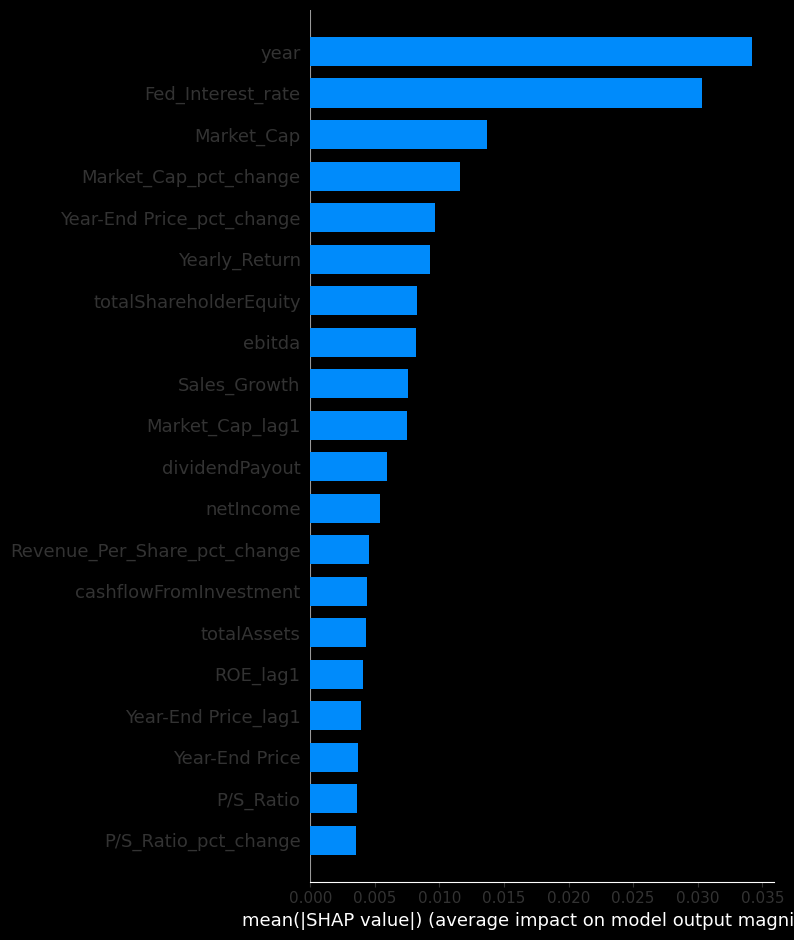

In [ ]:
# Hacemos el feature importance de Shap

model.fit(X_train, y_train)

explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_train)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train, feature_names=X.columns, plot_type="bar")


In [ ]:
pd.Series(data=features, index=columnas).sort_values(ascending=False)

,0
year,0.05
Fed_Interest_rate,0.04
Yearly_Return,0.03
Year-End Price_pct_change,0.03
Year-End Price_lag1,0.03
Market_Cap_pct_change,0.03
Market_Cap,0.02
P/S_Ratio_lag1,0.02
Year-End Price,0.02
ROIC_pct_change,0.02


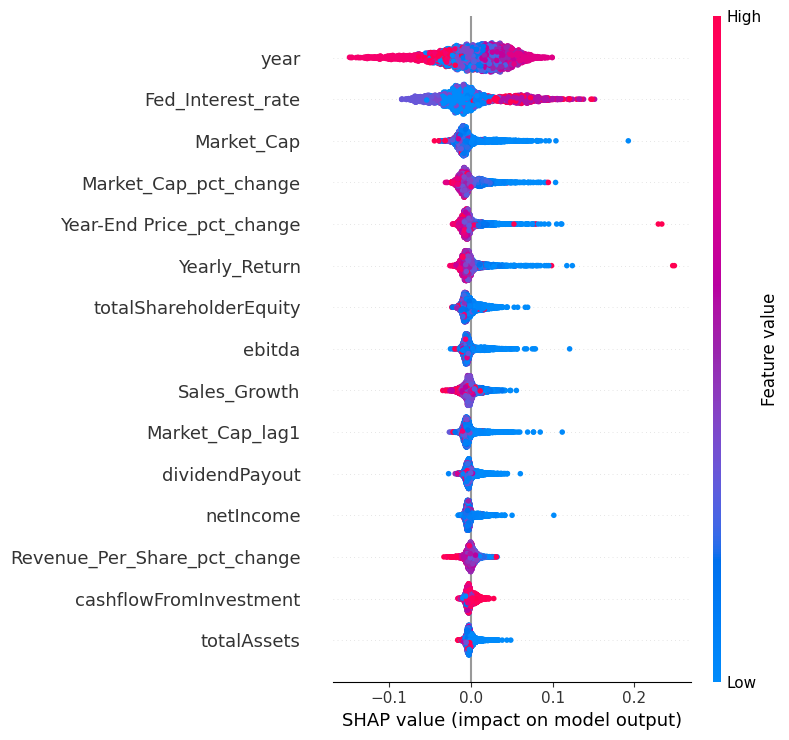

In [ ]:
import shap
import matplotlib.pyplot as plt

# Estilo con fondo blanco
plt.style.use('default')  # Restaura el estilo predeterminado

shap.summary_plot(shap_values, X_train, feature_names=X.columns, max_display=15)
plt.show()

# ¿Que hubiera pasado si hubieramos invertido en 2023 usando nuestro modelo?

In [ ]:
X_23_24.head(10)

,year,totalRevenue,depreciationAndAmortization,ebitda,netIncome,cashAndCashEquivalentsAtCarryingValue,totalLiabilities,totalShareholderEquity,commonStockSharesOutstanding,shortLongTermDebtTotal,capitalExpenditures,cashflowFromInvestment,dividendPayout,cashflowFromFinancing,operatingCashflow,Year-End Price,totalAssets,totalCurrentAssets,totalCurrentLiabilities,ROE,ROIC,Debt_to_Equity,Earnings_Per_Share,P/E_Ratio,Net_Income_Margin,Revenue_Per_Share,P/S_Ratio,Market_Cap,Yearly_Return,Sales_Growth,Fed_Interest_rate,Year_End_Price_MA_3Y,Year_End_Price_MA_5Y,ROE_lag1,ROIC_lag1,Debt_to_Equity_lag1,Earnings_Per_Share_lag1,P/E_Ratio_lag1,Net_Income_Margin_lag1,Revenue_Per_Share_lag1,P/S_Ratio_lag1,Market_Cap_lag1,Year-End Price_lag1,ROE_pct_change,ROIC_pct_change,Debt_to_Equity_pct_change,Earnings_Per_Share_pct_change,P/E_Ratio_pct_change,Net_Income_Margin_pct_change,Revenue_Per_Share_pct_change,P/S_Ratio_pct_change,Market_Cap_pct_change,Year-End Price_pct_change
10,2023,6784000000.00,140000000.00,1574000000.00,1240000000.00,1590000000.00,4918000000.00,5845000000.00,292123241.00,2735000000.00,298000000.00,-310000000.00,265000000.00,-930000000.00,1772000000.00,138.32,10763000000.00,4186000000.00,1603000000.00,0.21,1158778975.19,0.84,4.24,32.59,0.18,23.22,5.96,40407148694.81,-0.06,0.00,4.50,147.53,128.14,0.24,1018982207.77,0.99,4.25,34.77,0.19,22.96,6.44,43605916897.32,147.82,-0.10,0.14,-0.15,-0.00,-0.06,-0.01,0.01,-0.07,-0.07,-0.06
21,2023,379352000000.00,11519000000.00,125820000000.00,96995000000.00,29965000000.00,290437000000.00,62146000000.00,15550061000.00,111088000000.00,10959000000.00,3705000000.00,15025000000.00,-108488000000.00,110543000000.00,191.59,352583000000.00,143566000000.00,145308000000.00,1.56,17539458195.75,4.67,6.24,30.72,0.26,24.40,7.85,2979265797737.75,0.49,-0.03,4.50,164.96,139.16,1.97,14251693951.66,5.96,6.26,20.54,0.25,24.55,5.24,2050031775789.98,128.58,-0.21,0.23,-0.22,-0.00,0.50,0.00,-0.01,0.50,0.45,0.49
32,2023,54318000000.00,7900000000.00,16364000000.00,4863000000.00,12814000000.00,124351000000.00,10360000000.00,1768000000.00,59245000000.00,777000000.00,-2009000000.00,10539000000.00,-17222000000.00,22839000000.00,149.46,134711000000.00,33002000000.00,37841000000.00,0.47,-472882083.78,12.00,2.75,54.34,0.09,30.72,4.86,264237089488.61,-0.00,-0.06,4.50,140.00,116.54,0.69,254513924.20,7.04,6.68,22.41,0.20,32.78,4.57,265288216865.28,149.80,-0.32,-2.86,0.70,-0.59,1.42,-0.56,-0.06,0.06,-0.00,-0.00
36,2023,9917000000.00,57000000.00,1575000000.00,4792000000.00,6874000000.00,12480000000.00,8165000000.00,640000000.00,2304000000.00,47000000.00,-1042000000.00,0.00,-2430000000.00,3884000000.00,136.14,20645000000.00,16509000000.00,9950000000.00,0.59,3135150641.03,1.53,7.49,18.18,0.48,15.50,8.79,87129600000.00,0.59,0.19,4.50,129.38,129.38,0.34,1004493223.90,1.88,2.98,28.71,0.23,13.12,6.52,54339097500.00,85.50,0.72,2.12,-0.19,1.51,-0.37,1.13,0.18,0.35,0.60,0.59
47,2023,39431000000.00,1966000000.00,9267000000.00,5723000000.00,6896000000.00,34611000000.00,38603000000.00,1739235000.00,14679000000.00,2202000000.00,-3133000000.00,3556000000.00,-7091000000.00,7261000000.00,107.90,73214000000.00,22670000000.00,13841000000.00,0.15,2416939730.14,0.90,3.29,32.79,0.15,22.67,4.76,187662258525.93,0.02,-0.08,4.50,115.48,105.59,0.19,3521669421.49,1.03,3.98,26.53,0.16,24.72,4.27,183944188386.75,105.51,-0.22,-0.31,-0.13,-0.17,0.24,-0.10,-0.08,0.11,0.02,0.02
58,2023,13634000000.00,95000000.00,3798000000.00,4443000000.00,917000000.00,40551000000.00,18353000000.00,373400000.00,2726000000.00,52000000.00,-5468000000.00,40000000.00,-69000000.00,5749000000.00,70.63,58906000000.00,2117000000.00,20031000000.00,0.24,1992756257.55,2.21,11.90,5.94,0.33,36.51,1.93,26372719137.48,0.18,0.42,4.50,57.53,49.54,0.11,528365742.96,2.72,3.99,14.98,0.15,25.96,2.30,22110376521.45,59.70,1.12,2.77,-0.19,1.99,-0.60,1.12,0.41,-0.16,0.19,0.18
69,2023,64111745000.00,453205000.00,9508089000.00,6871557000.00,9045032000.00,25552466000.00,25692839000.00,629922331.00,147903000.

In [ ]:
# Hacemos nuestra prediccion del target de 2023-2024
y_23_24_pred = model.predict(X_23_24)

In [ ]:
# Nos guardamos el indice par poder asignarlo a los resultados:
indice_ticker_df_23_24 = indice_ticker_df.loc[X_23_24.index]
indice_ticker_df_23_24.head()

,ticker
10,A
21,AAPL
32,ABBV
36,ABNB
47,ABT


In [ ]:
# Creamos un dataframe con el ticker y su prediccion de target
y_23_24_pred_df = pd.DataFrame(y_23_24_pred, index=indice_ticker_df_23_24.index)
y_23_24_pred_df['ticker'] = indice_ticker_df_23_24
top_20_prediction = y_23_24_pred_df.sort_values(by=0, ascending=False).head(20)
top_20_prediction

,0,ticker
1182,0.89,CRWD
1576,0.85,EBAY
4138,0.83,RCL
5088,0.83,WBD
4845,0.82,UBER
1979,0.82,FIS
2519,0.81,IFF
3952,0.81,PLTR
848,0.80,CCL
1297,0.80,CZR


In [ ]:
# Creamos un dataframe que compara por cada ticker el target predicho y el target real

top_20_2024_return = df_copy[(df_copy['ticker'].isin(top_20_prediction['ticker'].tolist())) & (df_copy['year'] == 2023)][['next_year_return']]
top20_prediction_sorted = top_20_prediction.sort_index()
comparacion_predicted_real = pd.concat([top20_prediction_sorted, top_20_2024_return], axis=1).set_index('ticker')
comparacion_predicted_real.columns = ['predicted_return', 'real_return']
comparacion_predicted_real

,predicted_return,real_return
ticker,,
ALL,0.77,0.41
BA,0.78,-0.32
BAX,0.77,-0.23
BKR,0.75,0.22
CCL,0.80,0.34
CINF,0.73,0.42
CRWD,0.89,0.34
CZR,0.80,-0.29
EBAY,0.85,0.45


In [ ]:
top20_mean_return = df_copy[(df_copy['ticker'].isin(top_20_prediction['ticker'].tolist())) & (df_copy['year'] == 2023)][['next_year_return']].mean()[0]

print(f'El retorno obtenido si hubieramos invertido en nuestra prediccion del top 20:  {round(top20_mean_return*100, 2)} %')

El retorno obtenido si hubieramos invertido en nuestra prediccion del top 20:  43.77 %


In [ ]:
total_mean_return = df_copy[df_copy['year'] == 2023][['next_year_return']].mean() [0]

print(f'El retorno obtenido si hubieramos invertido en todas las empresas del S&P500:  {round(total_mean_return*100, 2)} %')

El retorno obtenido si hubieramos invertido en todas las empresas del S&P500:  14.67 %
